In [8]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
from sklearn.metrics import auc
from sklearn import metrics

In [3]:
# Cargamos el dataset
dataset = pd.read_csv('/content/class_7_wine_dataset_v2 (3).csv')

In [4]:
# Obtenemos una descripción rápida del dataset:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            6497 non-null   int64  
 1   type                  6497 non-null   object 
 2   fixed acidity         6487 non-null   float64
 3   volatile acidity      6489 non-null   float64
 4   citric acid           6494 non-null   float64
 5   residual sugar        6495 non-null   float64
 6   chlorides             6495 non-null   float64
 7   free sulfur dioxide   6497 non-null   float64
 8   total sulfur dioxide  6497 non-null   float64
 9   density               6497 non-null   float64
 10  pH                    6488 non-null   float64
 11  sulphates             6493 non-null   float64
 12  alcohol               6497 non-null   float64
 13  quality               6497 non-null   int64  
 14  vendor_id             6497 non-null   int64  
dtypes: float64(11), int64

In [7]:
# Muestra valores
print(dataset.head())
print(len(dataset))

   Unnamed: 0   type  fixed acidity  volatile acidity  citric acid  \
0           0  white            7.0              0.27         0.36   
1           1  white            6.3              0.30         0.34   
2           2  white            8.1              0.28         0.40   
3           3  white            7.2              0.23         0.32   
4           4  white            7.2              0.23         0.32   

   residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  \
0            20.7      0.045                 45.0                 170.0   
1             1.6      0.049                 14.0                 132.0   
2             6.9      0.050                 30.0                  97.0   
3             8.5      0.058                 47.0                 186.0   
4             8.5      0.058                 47.0                 186.0   

   density    pH  sulphates  alcohol  quality  vendor_id  
0   1.0010  3.00       0.45      8.8        6        369  
1   0.9940

In [9]:
quality = dataset.quality.to_numpy()

(array([  30.,  216.,    0., 2138.,    0., 2836., 1079.,    0.,  193.,
           5.]),
 array([3. , 3.6, 4.2, 4.8, 5.4, 6. , 6.6, 7.2, 7.8, 8.4, 9. ]),
 <a list of 10 Patch objects>)

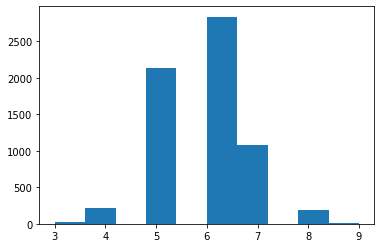

In [12]:
fig, ax1 = plt.subplots(1,1)
ax1.hist(quality)

In [13]:
print(np.unique(quality))

[3 4 5 6 7 8 9]


In [14]:
# Convertimos el problema de clasificación en binario, ya que tiene clases muy desbalanceadas

dataset['quality_target'] = dataset.quality.apply(lambda label: 0 if label<=6 else 1)
print(len(dataset[dataset['quality_target'] == 0]))
print(len(dataset[dataset['quality_target'] == 1]))

5220
1277


## LIMPIAMOS EL DATASET

In [17]:
nans = dataset[dataset.isna().sum(axis = 1) >= 1]
print(nans.shape)

(34, 16)


In [20]:
# Directamente borramos las filas que tienen datos nulos
ds = dataset[dataset.isna().sum(axis = 1) == 0]
print(ds.shape)

(6463, 16)


### INGENIERÍA DE FEATURES

In [21]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6463 entries, 0 to 6496
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            6463 non-null   int64  
 1   type                  6463 non-null   object 
 2   fixed acidity         6463 non-null   float64
 3   volatile acidity      6463 non-null   float64
 4   citric acid           6463 non-null   float64
 5   residual sugar        6463 non-null   float64
 6   chlorides             6463 non-null   float64
 7   free sulfur dioxide   6463 non-null   float64
 8   total sulfur dioxide  6463 non-null   float64
 9   density               6463 non-null   float64
 10  pH                    6463 non-null   float64
 11  sulphates             6463 non-null   float64
 12  alcohol               6463 non-null   float64
 13  quality               6463 non-null   int64  
 14  vendor_id             6463 non-null   int64  
 15  quality_target       

In [25]:
# Analisis de la variable TYPE
print(ds['type'].unique())
type_dummies = pd.get_dummies(ds['type'], prefix= 'type')
type_dummies.info()
# Concatenamos al dataset original
ds = pd.concat([ds, type_dummies], axis = 1)
ds.info()

['white' 'red']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6463 entries, 0 to 6496
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   type_red    6463 non-null   uint8
 1   type_white  6463 non-null   uint8
dtypes: uint8(2)
memory usage: 63.1 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6463 entries, 0 to 6496
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            6463 non-null   int64  
 1   type                  6463 non-null   object 
 2   fixed acidity         6463 non-null   float64
 3   volatile acidity      6463 non-null   float64
 4   citric acid           6463 non-null   float64
 5   residual sugar        6463 non-null   float64
 6   chlorides             6463 non-null   float64
 7   free sulfur dioxide   6463 non-null   float64
 8   total sulfur dioxide  6463 non-null   float64
 9   density   

In [27]:
# Analizamos la variable  VENDOR
print(len(ds['vendor_id'].unique()))

500


(array([  19.,   93.,  334., 1466., 1795., 1699.,  743.,  257.,   88.,
           3.]),
 array([  1. ,  70.2, 139.4, 208.6, 277.8, 347. , 416.2, 485.4, 554.6,
        623.8, 693. ]),
 <a list of 10 Patch objects>)

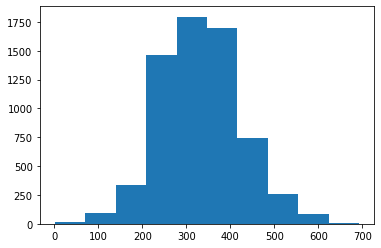

In [31]:
vendor_id = dataset.vendor_id.to_numpy()
fig, ax1 = plt.subplots(1,1)
ax1.hist(vendor_id,bins = 10)

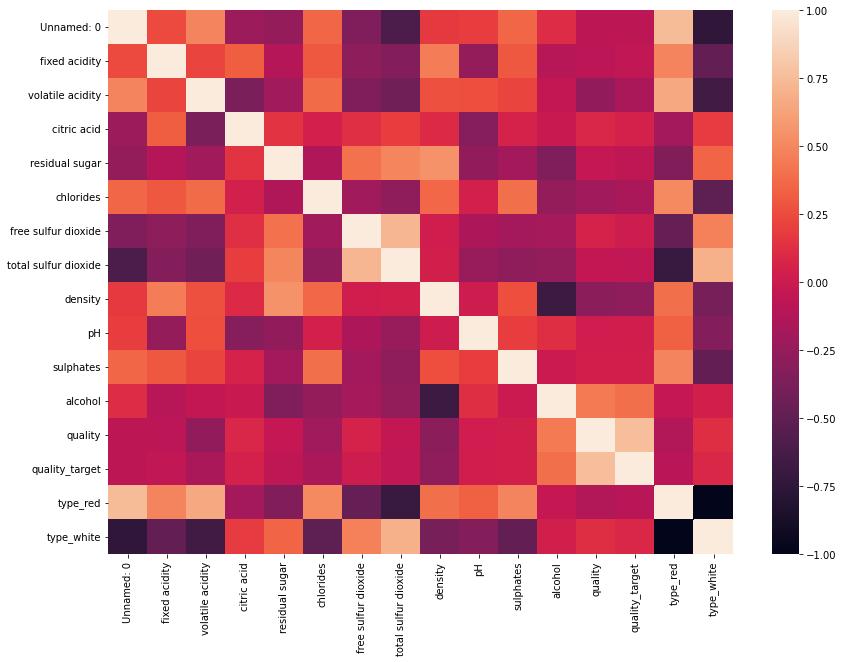

In [36]:
# Analizamos las variables reales
corr = ds.loc[:, (ds.columns != "vendor_id") & (ds.columns != "type") & (ds.columns != "quality_label")].corr()
fig, ax1 = plt.subplots(1, figsize=(14,10))
import seaborn as sns
sns.heatmap(corr)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


{'boxes': [<matplotlib.lines.Line2D at 0x7f05fcd42290>,
 'caps': [<matplotlib.lines.Line2D at 0x7f05fcd47310>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f05fcd4e350>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f05fcd47dd0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f05fcd42850>,
  <matplotlib.lines.Line2D at 0x7f05fcd57490>]}

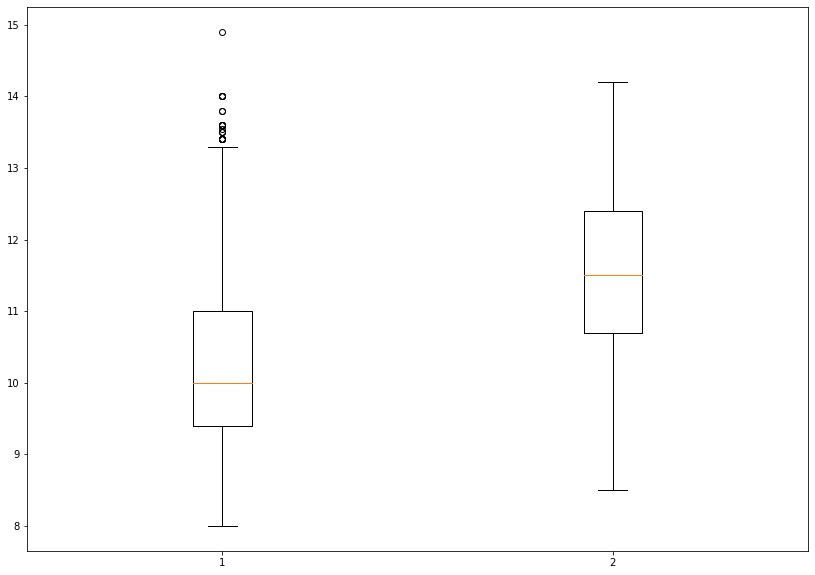

In [43]:
fig, ax1 = plt.subplots(1, figsize=(14, 10))
ax1.boxplot([ds.loc[ds["quality_target"] == 0, "alcohol"], 
            ds.loc[ds["quality_target"] == 1, "alcohol"]])

In [70]:
vendor_id = ds['vendor_id']
quality_label = ds['quality_target']
quality_label = quality_label.to_numpy()
final_ds = ds.drop(['Unnamed: 0', 'quality_target', 'quality', 'vendor_id', 'type'], axis =1, inplace = False)


### NORMALIZAMOS

In [71]:
nds = (final_ds - np.min(final_ds, axis = 0)) / (np.max(final_ds, axis = 0) - np.min(final_ds, axis = 0))

In [72]:
print(np.max(nds,axis = 0))
print(np.min(nds,axis = 0))


fixed acidity           1.0
volatile acidity        1.0
citric acid             1.0
residual sugar          1.0
chlorides               1.0
free sulfur dioxide     1.0
total sulfur dioxide    1.0
density                 1.0
pH                      1.0
sulphates               1.0
alcohol                 1.0
type_red                1.0
type_white              1.0
dtype: float64
fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
type_red                0.0
type_white              0.0
dtype: float64


In [54]:
nds.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
0,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.377880,0.267785,0.217054,0.129213,0.115942,0.0,1.0
1,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.132832,0.449612,0.151685,0.217391,0.0,1.0
2,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.154039,0.418605,0.123596,0.304348,0.0,1.0
3,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,0.0,1.0
4,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,0.0,1.0


nds = nds.to_numpy()

In [73]:
nds = nds.to_numpy()

# split

In [74]:
n = nds.shape[0]
idx = np.random.permutation(np.arange(0, n)) # 100, 2, 0, 40, ...
train_idx = idx[:int(0.85 * n)]
val_idx = idx[int(0.85 * n):]
assert len(idx) == len(train_idx) + len(val_idx)

X_train = nds[train_idx,:]
y_train = quality_label[train_idx]

X_val = nds[val_idx,:]
y_val = quality_label[val_idx]

In [75]:
import torch
from torch.utils.data import Dataset, DataLoader

In [80]:
class CustomDataset(Dataset):
  def __init__(self, X, y):
    super().__init__()
    self.X = X
    self.y = y
  def __len__(self):
    return self.X.shape[0]
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [81]:
train = CustomDataset(X_train, y_train)
val = CustomDataset(X_val, y_val)

In [82]:
print(train[0])
type(train[0])
type(train[0][0])

(array([0.27272727, 0.06666667, 0.44578313, 0.23006135, 0.05813953,
       0.14930556, 0.39170507, 0.24079429, 0.51162791, 0.25280899,
       0.14492754, 0.        , 1.        ]), 0)


numpy.ndarray

In [84]:
train_dataloader = DataLoader(train, batch_size = 128, shuffle = True)
val_dataloader = DataLoader(val, batch_size = 128, shuffle = True)



In [85]:
print(iter(train_dataloader))

In [88]:
class NNet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_1 = torch.nn.Linear(in_features=13, out_features=200, bias = True)
    self.relu_1 = torch.nn.ReLU()
    self.linear_2 = torch.nn.Linear(in_features = 200, out_features = 100, bias = True)
    self.relu_2 = torch.nn.ReLU()
    self.linear_3 = torch.nn.Linear(in_features = 100, out_features = 1, bias = True)

  def forward(self, x):
    x = self.linear_1(x)
    x = self.relu_1(x)
    x = self.linear_2(x)
    x = self.relu_2(x)
    x = self.linear_3(x)
    return x

In [108]:
nnet = NNet()
print(nnet)

NNet(
  (linear_1): Linear(in_features=13, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=100, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=100, out_features=1, bias=True)
)


In [109]:
optimizer = torch.optim.Adam(nnet.parameters(), lr = 0.001)

In [110]:
loss_function = torch.nn.BCEWithLogitsLoss(reduction = 'sum')

In [111]:
device = ""
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

nnet.to(device)

auc_train_list = []
auc_val_list = []
for epoch in range(500):

    running_loss = 0
    running_y_score = []
    running_y_truth = []

    #### TRAINING ####

    nnet.train()

    for i, data in enumerate(train_dataloader):

        # data del batch
        X, y = data
        X = X.to(device).float()
        y = y.to(device).float().reshape(-1,1)

        # forward
        optimizer.zero_grad()
        y_hat = nnet(X)
        y_score = torch.sigmoid(y_hat)

        # backward
        loss = loss_function(y_hat, y)
        loss.backward()
        optimizer.step()

        # metrics
        running_loss += loss.item() 
        running_y_score += list(y_score.detach().numpy())
        running_y_truth += list(y.detach().numpy())

    fpr, tpr, thresholds = metrics.roc_curve(running_y_truth, running_y_score)
    auc_value = metrics.auc(fpr, tpr)
    auc_train_list.append(auc_value)
    # print("Loss en epoch {} = {} | AUC = {}".format(epoch, running_loss, auc_value))

    #### VALIDATION ####

    nnet.eval()
    with torch.no_grad():

        for i, data in enumerate(val_dataloader):

            # data del batch
            X, y = data
            X = X.to(device).float()
            y = y.to(device).float().reshape(-1,1)

            # forward
            optimizer.zero_grad()
            y_hat = nnet(X)
            y_score = torch.sigmoid(y_hat)

            # metrics
            running_loss += loss.item() 
            running_y_score += list(y_score.detach().numpy())
            running_y_truth += list(y.detach().numpy())

        fpr, tpr, thresholds = metrics.roc_curve(running_y_truth, running_y_score)
        auc_value = metrics.auc(fpr, tpr)
        auc_val_list.append(auc_value)
        print("Val loss en epoch {} = {} | AUC = {}".format(epoch, running_loss, auc_value))


Val loss en epoch 0 = 3440.197868347168 | AUC = 0.5218877556587087
Val loss en epoch 1 = 2970.322052001953 | AUC = 0.722409286695382
Val loss en epoch 2 = 2717.3830032348633 | AUC = 0.7710262656704802
Val loss en epoch 3 = 2546.111183166504 | AUC = 0.7869883037390938
Val loss en epoch 4 = 2590.225814819336 | AUC = 0.7986134936154272
Val loss en epoch 5 = 2571.877223968506 | AUC = 0.8082551349955569
Val loss en epoch 6 = 2482.4330444335938 | AUC = 0.8104061322933425
Val loss en epoch 7 = 2586.611961364746 | AUC = 0.8152453268903682
Val loss en epoch 8 = 2524.175464630127 | AUC = 0.8163293495167171
Val loss en epoch 9 = 2482.9780654907227 | AUC = 0.8187009852354102
Val loss en epoch 10 = 2473.408515930176 | AUC = 0.8225116956547567
Val loss en epoch 11 = 2427.3007621765137 | AUC = 0.8234994920467122
Val loss en epoch 12 = 2471.809841156006 | AUC = 0.8244626636149058
Val loss en epoch 13 = 2411.2966232299805 | AUC = 0.8283489911853739
Val loss en epoch 14 = 2345.10147857666 | AUC = 0.8296

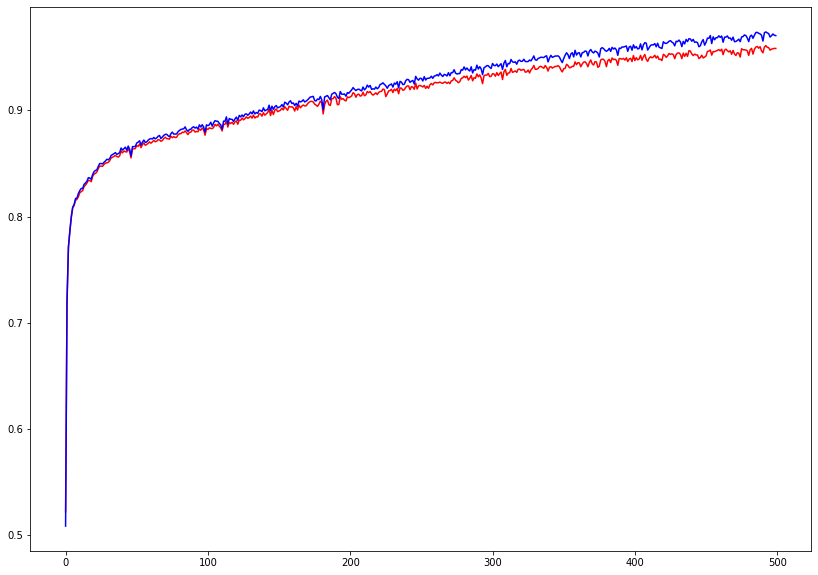

In [112]:
fig, ax1 = plt.subplots(1, figsize=(14, 10))
x = range(0, len(auc_val_list))
ax1.plot(x, auc_val_list, color="r")
ax1.plot(x, auc_train_list, color="b")

### MODELO CON EMBEDDINGS